# トピック分析3: LDA を用いた教師なし学習によるトピック分類

Tf-iDfの課題では、すでにカテゴリごとに分類された記事が大量に用意されていました。 
ですから、未分類の文書が与えられたら、分類済みの文書集合を「教師（supervisor)」として、モデルを教師あり学習（supervised learning)することができました。

しかし、全く未分類の文書集合がドンと与えられて、「これを適当に分類してね」と言われたらどうしたらいいでしょうか？   
あるいは、すでに分類済みであったとしても、「もっと他の分け方ないの？」と言われたら？   
（実はこういうことはよくあります。例えば大昔に決めたカテゴリでずっと分類してきたけれど、時代が変わって新しいカテゴリが次々と現れると、大昔のカテゴリ分類は使いづらくなって、改めてゼロからカテゴリを決めたくなるためです。）

そんなときは教師なし学習（unsupervised learning)によるトピック分類が有用です。   
ここではその一種である潜在的ディリクレ配分法（LDA: Latent Dirichlet Allocation）を使います。   


## 1. 前処理

人手でラベルが与えられている教師あり学習に比べて、教師なし学習で人間が納得できるような結果を得るためには、事前の処理が極めて重要です。   
一般的には次のような処理が行われます。

- 単語分割： 日本語では分かち書き、英語ではtokenizationと呼ぶ。先週、janomeを使った分かち書きの方法を学びました。
- ストップワード(Stopwords)除去：あまりに一般的過ぎる単語は、頻出する割にはその文書特有の性質を持たないため除去する
- ステミング(stemming)：英語において、語幹のみを取り出す処理(例：running --> run-ning, runs --> run-s, runner --> run-ner)。
- 見出し語化(lemmatize): ran --> runのように、原形に戻す処理。和文では活用形を原型に戻すなどの処理があります（例：「走っ(た)」-->「走る」）。こうすることにより、集計する際に同じ語彙からなる単語はまとめることができ、文書ベクトルがより密になります。

### 1.1 ストップワード除去

これがストップワードです！と決められたものはありません。   
和文でよく使われているのは、京都大学大学院 情報学研究科 社会情報学専攻 情報図書館学分野（旧・田中研究室）のスタッフや学生が開発してきたWeb情報検索ライブラリ[SlothLib](http://www.dl.kuis.kyoto-u.ac.jp/slothlib/)の中で読み込まれているStopwordsのリストのようです。   
その他、処理結果を見て除去したい単語を手作業で追加してもいいでしょう。


In [1]:
from urllib import request

# SlothLibのStopwordsリストをオンラインから取得
res = request.urlopen("http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt")
stop_words = [line.decode("utf-8").strip() for line in res]

# 処理結果を見て手作業でStopwrodsを追加
stop_words += ['する','れる','いる','ある','なる','られる','の','せる','おる','行う', '待つ', 'できる','呼ぶ','言う','用いる','持つ','いう']
print(stop_words)


['あそこ', 'あたり', 'あちら', 'あっち', 'あと', 'あな', 'あなた', 'あれ', 'いくつ', 'いつ', 'いま', 'いや', 'いろいろ', 'うち', 'おおまか', 'おまえ', 'おれ', 'がい', 'かく', 'かたち', 'かやの', 'から', 'がら', 'きた', 'くせ', 'ここ', 'こっち', 'こと', 'ごと', 'こちら', 'ごっちゃ', 'これ', 'これら', 'ごろ', 'さまざま', 'さらい', 'さん', 'しかた', 'しよう', 'すか', 'ずつ', 'すね', 'すべて', 'ぜんぶ', 'そう', 'そこ', 'そちら', 'そっち', 'そで', 'それ', 'それぞれ', 'それなり', 'たくさん', 'たち', 'たび', 'ため', 'だめ', 'ちゃ', 'ちゃん', 'てん', 'とおり', 'とき', 'どこ', 'どこか', 'ところ', 'どちら', 'どっか', 'どっち', 'どれ', 'なか', 'なかば', 'なに', 'など', 'なん', 'はじめ', 'はず', 'はるか', 'ひと', 'ひとつ', 'ふく', 'ぶり', 'べつ', 'へん', 'ぺん', 'ほう', 'ほか', 'まさ', 'まし', 'まとも', 'まま', 'みたい', 'みつ', 'みなさん', 'みんな', 'もと', 'もの', 'もん', 'やつ', 'よう', 'よそ', 'わけ', 'わたし', '', 'ハイ', '', '', '上', '中', '下', '字', '', '', '年', '月', '日', '時', '分', '秒', '週', '火', '水', '木', '金', '土', '国', '都', '道', '府', '県', '市', '区', '町', '村', '', '', '各', '第', '方', '何', '的', '度', '文', '者', '性', '体', '人', '他', '今', '部', '課', '係', '外', '類', '達', '気', '室', '口', '誰', '用', '界', '会', '首', '男', '女', '別', '話', '私', '屋', '店', '家', '場'

### 1.2 見出し語化・品詞による絞り込み

今回は、機能語の中でも特に重要と思われる「名詞」「動詞」「形容詞」の単語のみに限定し、かつ活用形を原型に戻したものを使います。   
その結果を`texts/wikipedia_base_form_nva.json`に保存してあるので、それを読み込みます。   
これは下のようなものです。

元の文章：  
`脳 科学 （ の う か がく 、 ） と は 、 ヒト を 含む 動物 の 脳 と 、 それ が 生み出す 機能 について 研究 する 学問 分野 で ある 。 `

変換後の文章：  
`脳 科学 がく ヒト 含む 動物 脳 生み出す 機能 研究 学問 分野 対象`

さらにストップワードを除去します。

In [2]:
import json
import numpy as np


# Wikipediaを読み込み
Categories = ['animal', 'art', 'economy', 'law', 'plant', 'politics']

with open('texts/wikipedia_base_form_nva.json', 'r', encoding='utf-8') as fi:
    wiki = json.load(fi)

rv_cate = [] # 「正解のカテゴリ分類」を入れるリスト(以下の分類では「わからないもの」とし、使用しない。)
base_form_nva = [] # 各記事ごとに、単語を並べたリスト
for cate in Categories:
    for item in wiki[cate]:
        tmp = []
        for word in wiki[cate][item]['base_form_nva'].split():
            # さらにストップワードを除去します
            if word not in stop_words and not word.isdigit():
                tmp.append(word)
        base_form_nva.append(tmp)
        rv_cate.append(cate)
        
print('全カテゴリの記事数: ', len(base_form_nva))

全カテゴリの記事数:  2101


記事の総数は2101です。   
これらのカテゴリは以下に出力する通りです。  
ただし、今回は、『文書が分類されていなかったときの分類』を行うことが目的ですので、これらのカテゴリラベルは学習には使用しません。これは『（機械は知らない）正解のカテゴリ分類結果』と考えてください。

In [3]:
print(rv_cate)

['animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal', 'animal',

## 2. LDAの学習と評価

### 2.1 モデル学習
トピックモデルを簡単に実装できるgensimというライブラリを使って、LDAモデルを学習してみましょう。   
LDAの結果はパラメータによって大きく変わります。   

トピック数は、「この文書はいくつのトピックに分けられるか」を考えて決めましょう。   
これは6カテゴリから抽出した記事ですから、少なくとも6個のトピックはあると考えられるかもしれません。   
また、同じカテゴリでも複数のトピックを含む場合もあるでしょう。   
もちろん、複数のカテゴリに現れるトピックもあるでしょう。   
ここではとりあえず10個のトピックに分けて見ましょう。

また、辞書を作る際、Tf-iDfのときと同じように、すべての単語を考慮すると次元が大きくなりすぎるので、
考慮する単語を絞り込みたいと思います。   
ここでは、最低出現回数、最大出現頻度、単語数の上限などを指定しています。   

このようなパラメータは、これと決まった数字があるわけではありません。   
結果を見ながら、手作業でのパラメータチューニングする必要があります。

**環境によってはWarningが出るかもしれませんが、とりあえず気にしないでください。**gensimの中で使っているライブラリがアップデートされてバージョンコンフリクトを起こしているためだと思われます。

In [4]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

# LDAはランダムパラメータを使うので、実行するたびに結果が変わります
# 毎回同じ結果を出したいときは、ランダムシードを設定する必要があります
SOME_FIXED_SEED = 6
np.random.seed(SOME_FIXED_SEED)

# いくつのトピックに分類するかを指定します。この数が増えれば増えるほど、細かく分類されます
topic_n =10

# 辞書を作成
dictionary = Dictionary(base_form_nva)
# パラメータを設定
dictionary.filter_extremes(no_below=100,# 出現文書数が100回未満の単語を削除
                           no_above=0.5,# 出現文書率が50％より大きい単語を削除
                           keep_n=1000) # 1000単語以上には増やさない

# 各文書をBag-of-Wordsにより文書ベクトルに変換
corpus_bow = [dictionary.doc2bow(text) for text in base_form_nva]

# LDAの学習
lda = LdaModel(corpus=corpus_bow, num_topics=topic_n, id2word=dictionary)

# LDAの学習には時間がかかるので、学習したモデルは保存しておきましょう
model_pref = 'model/wikipedia_lda'
lda.save(model_pref)

/Users/nishiyamaakito/.pyenv/versions/3.6.5/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/nishiyamaakito/.pyenv/versions/3.6.5/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [5]:
# モデルの読み込みは以下のようにして行います
lda = LdaModel.load(model_pref)

print(dictionary) # 辞書に登録された単語を見てみましょう
print(len(dictionary)) # 辞書に登録されている語彙数を見てみましょう


Dictionary(767 unique tokens: ['みる', 'より', 'よる', 'ら', 'テレビ']...)
767


/Users/nishiyamaakito/.pyenv/versions/3.6.5/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/Users/nishiyamaakito/.pyenv/versions/3.6.5/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### 2.2 各トピックにおける重要語とその重み

ここでは、各トピックごとに、重要度の高かった単語上位5個とその重みを出力しています。   
この時点で、トピックごとに見ていったとき、そのトピックがどのようなまとまりであるかが分かるような単語が並んでいるが成功の目安となります。   


In [6]:
for tpn in range(topic_n):
    print('トピック', tpn, ': ', lda.print_topic(tpn, topn = 5))


トピック 0 :  0.019*"-" + 0.014*"主義" + 0.013*"州" + 0.011*"国家" + 0.010*"植物"
トピック 1 :  0.057*"項" + 0.042*"委員" + 0.038*"契約" + 0.037*"条" + 0.030*"地方"
トピック 2 :  0.036*"憲法" + 0.022*"権" + 0.016*"条" + 0.012*"国家" + 0.011*"規定"
トピック 3 :  0.025*"経済" + 0.018*"主義" + 0.016*"強制" + 0.014*"産業" + 0.014*"問題"
トピック 4 :  0.060*"政治" + 0.027*"政府" + 0.025*"国家" + 0.018*"学" + 0.015*"主義"
トピック 5 :  0.040*"政治" + 0.021*"国家" + 0.020*"社会" + 0.020*"学" + 0.015*"主義"
トピック 6 :  0.027*"文化" + 0.017*"国際" + 0.012*"適用" + 0.012*"民間" + 0.011*"中国"
トピック 7 :  0.025*"社会" + 0.018*"女性" + 0.015*"政治" + 0.013*"主義" + 0.011*"史"
トピック 8 :  0.021*"花" + 0.015*"植物" + 0.014*"種" + 0.011*"科" + 0.011*"属"
トピック 9 :  0.025*"種" + 0.014*"状" + 0.013*"植物" + 0.011*"葉" + 0.010*"花"


たとえば以下のようなことが分かるでしょうか。

- トピック2は憲法に関する内容
- トピック3は経済に関する内容
- トピック4と5は政治的な内容
- トピック6は文化に関する内容
- トピック8と9は植物に関する内容


## 3. LDAモデルの性能を調べてみよう

はたして、このLDAモデルはWikipediaを分類できたでしょうか？

LDAは、カテゴリ分類されていない文書集合を分類するものですから、今回のように「動物」「芸術」「経済」というような正解のカテゴリラベルがあるというのはおかしいのですが、今回はこのカテゴリ通りに記事を分類できたかどうかでLDAの分類性能を評価することにします。

学習済みのモデル`lda`に対し、各記事の文書ベクトル`corpus_bow`を渡すと、尤度が高かった順に、そのトピック番号と尤度のペアが返されます。   
例えば4番目の記事（記事のタイトルは「動物学」、カテゴリは『動物』）のbowを渡すと、第1位のトピックはトピック8で尤度は0.68、第2位のトピックは5で尤度は0.29、第3位のトピックは6で尤度は0.01のようです。

In [7]:
sorted(lda[corpus_bow[4]], key=lambda x: x[1], reverse=True)

[(8, 0.688418), (5, 0.29616845), (6, 0.013204719)]

分類結果を積み上げグラフで描画してみましょう。   

animal
art
economy
law
plant
politics


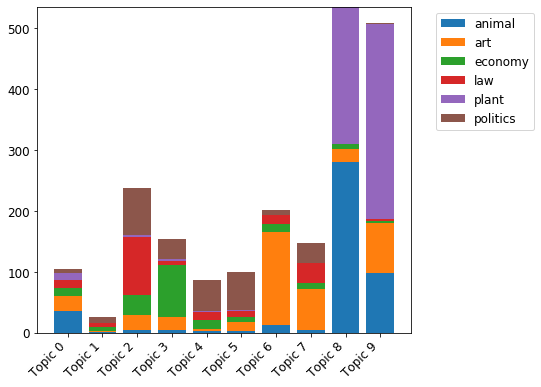

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

height = []
for cate in Categories:
    best = [0] * (topic_n)
    for art_n in range(len(base_form_nva)):
        if rv_cate[art_n] == cate:
            # 尤度が最も高かったトピックを分類結果とする
            best[sorted(lda[corpus_bow[art_n]], key=lambda x: x[1], reverse=True)[0][0]] += 1 
    height.append(best)
    print(cate)

plt.figure(figsize=(8,6))
plt.rcParams["font.size"] = 12
plt.subplot(1,1,1)
btm = np.array([0] * (topic_n))
for cate_n in range(len(Categories)):
    plt.bar(range(topic_n), height[cate_n], bottom=btm, 
            tick_label=['Topic {:d}'.format(i) for i in range(topic_n)], 
            align="center")
    btm += np.array(height[cate_n])

plt.xticks(rotation=45, horizontalalignment='right')
plt.legend(Categories, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(left = 0.1, right = 0.75)
plt.savefig('fig/TopicAnalysis2-1.png') # 図を画像として保存

各トピックの重要語から、トピックの性質は以下のようになっていると考えていたはずです。

- トピック2は憲法に関する内容
- トピック3は経済に関する内容
- トピック4と5は政治的な内容
- トピック6は文化に関する内容
- トピック8と9は植物に関する内容

その通りに分類されているでしょうか？

今度はWikipediaの分類による各カテゴリの記事が、どの程度の割合で各トピックに分類されたかを可視化してみましょう。

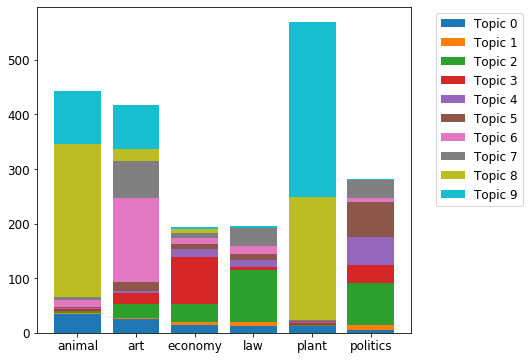

In [9]:
height2 = np.array(height).T

plt.figure(figsize=(8,6))
plt.rcParams["font.size"] = 12

plt.subplot(1,1,1)
btm = [0] * len(Categories)
for tpn in range(topic_n):
    plt.bar(range(len(Categories)), height2[tpn], bottom=btm, tick_label=Categories, align="center")
    btm += height2[tpn]

plt.legend(['Topic {:d}'.format(i) for i in range(topic_n)], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(left = 0.1, right = 0.75)
plt.savefig('fig/TopicAnalysis1-2.png') # 図を画像として保存

横軸はWikipediaで指定されているカテゴリです。   
- 『動物』と『植物』のカテゴリの記事は、概ねトピック８と９に分かれるようです。
- トピック6に分類された記事はほとんど『文化』の記事のようです
- トピック3に分類された記事はほとんど『経済』の記事のようです

教師なし学習を実用で使う場合は、結果を見ながらパラメータを調整する必要があります。   
また、LDAは最初にランダム値をセットするため、計算するたびに答えが変わります（今回はrandom seedを指定しているため変わりません）。   
1回うまくいったからと言って、そのパラメータが必ずしも絶対的にいいとは言えないので注意が必要です。